# AI in Finance Project: Buy the Close, Sell the Open

### Completed by: Andrew Niedzialek & Menaka Kiriwattuduwa

## Hypothesis

It has been found that buying equities at market close and selling them the next morning at open is a profitable strategy. The goal of this project was to develop an optimized trading model to take advantage of this market phenomenon.

More details on this hypothesis can be found in the following link:
- https://www.businessinsider.com/stocks-fall-during-regular-trading-hours-rise-overnight-2016-3  

When developing the trading model, the machine learning workflow discussed in class was used. The sections of this notebook reflect the key stages outlined in this workflow. The first part of the notebook focusses on data engineering. The raw data was obtained and cleaned. From here, features were generated and the data was scaled. The most salient features were selected for use in model development.

During model development, three different machine learning models were selected: linear regression, random forest and gradient-boosted decision trees. For each of these models, hyperparameter tuning was performed. The models were evaluated in two ways. First, the predictive performance of each model was considered. The financial performance of the resulting strategy was also examined.

In [1]:
# The modules below must be imported to run the program.
# All modules have already been installed as per the Anaconda installation instructions
# provided in Lecture 1 of the course.

#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import datetime as dt
import math
import math
from matplotlib import pyplot
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

In [2]:
#Silence some annoying errors
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Use decimals instead of scientific notation
np.set_printoptions(suppress=True)

In [3]:
#Set directory
# os.chdir('/Users/19052/Desktop/')

In [4]:
#Reused function from class
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    x_const = sm.add_constant(x) #need to add intercept constant
    model = sm.OLS(y,x_const)
    result = model.fit()
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    #the residuals are the detrended prices
    resid = y-y_hat
    #add minimum necessary to residuals to avoid negative detrended prices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid 

## Importing Data 

Data was obtained from WRDS.

For this analysis, stocks from a single sector were selected with the assumption that they would share similar characteristics that our model could identify. In this case, the top 10 US Tech stocks were chosen. 

In [5]:
#pulling in data, top 10 US tech stocks by market cap (omitted TSLA, because not really tech))
StackedPrices = pd.read_csv("TechStocks.csv")
StackedPrices.date = pd.to_datetime(StackedPrices.date) 
StackedPrices.PRC = abs(StackedPrices.PRC) 

#Dropping these features for now
StackedPrices = StackedPrices.drop(['PERMNO'], axis = 1)
StackedPrices = StackedPrices.drop(['BID'], axis = 1)
StackedPrices = StackedPrices.drop(['ASK'], axis = 1)
StackedPrices = StackedPrices.drop(['NUMTRD'], axis = 1)

#Added high and low of day
#StackedPrices = StackedPrices.drop(['BIDLO'], axis = 1)
#StackedPrices = StackedPrices.drop(['ASKHI'], axis = 1) 

#Remove voting shares of Google and sorting
StackedPrices = StackedPrices[StackedPrices['TICKER'] != "GOOGL"] 
StackedPrices.sort_values(by=['TICKER', 'date'], inplace=True)

StackedPrices.head()

,date,TICKER,BIDLO,ASKHI,PRC,VOL,OPENPRC
4024,2016-01-04,AAPL,102.00,105.368,105.35,69383612,102.61
4025,2016-01-05,AAPL,102.41,105.850,102.71,55791042,105.75
4026,2016-01-06,AAPL,99.87,102.370,100.70,68487388,100.56
4027,2016-01-07,AAPL,96.43,100.130,96.45,81466204,98.68
4028,2016-01-08,AAPL,96.76,99.110,96.96,70798746,98.55


In [6]:
#useful function for unpivoting tables
def MyStack(X):
    X = X.stack(dropna=False)
    X.reset_index(inplace=True)
    X.sort_values(by=['TICKER', 'date'], inplace=True)
    return(X)

In [7]:
#list of tickers
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

#List of values
Values = ['PRC','VOL', 'OPENPRC', 'ASKHI', 'BIDLO']

# For splitting data
TestYear = 2019

In [8]:
#Unstacking Data
UnstackedPrices = pd.pivot_table(StackedPrices, values=Values, index=['date'], columns=['TICKER'], aggfunc=np.sum)

## Feature Engineering Part 1

Several features were explored. Many of these features aimed to incorporate temporal aspects of the raw data. Some commonly used techniques for feature engineering of time series data includes the use of rolling windows. These types of features represent a summary of the values over the previous n time steps, where n is the size of the window.

In [9]:
#Adding rolling window features

#20 day rolling standard deviation of price
for i in Tick:
    UnstackedPrices['20STDPRC', i] = UnstackedPrices['PRC', i].rolling(window=20).std()

#5 day rolling standard deviation of price
for ii in Tick:
    UnstackedPrices['5STDPRC', ii] = UnstackedPrices['PRC', ii].rolling(window=5).std()
    
#5 day rolling mean of price
for iii in Tick:
    UnstackedPrices['5AVGPRC', iii] = UnstackedPrices['PRC',iii].rolling(window=5).mean()
    
#5 day rolling stdev of volume
for iiii in Tick:
    UnstackedPrices['5STDVOL', iiii] = UnstackedPrices['PRC',iiii].rolling(window=5).mean()

#Open Price day of trade
OpenPrc1 = UnstackedPrices['OPENPRC'].shift(periods=-1)

for v in Tick:
    UnstackedPrices['OPENTRD', v] = OpenPrc1[v] 

Scaling is also an important part of feature engineering. For some models, scaling is crucial. This is especially true for distance-based models since the similarity between values is evaluated using the distance between data points. Although some of the models in this analysis are not as sensitive to feature scaling, standardization was still performed to maintain consistency.

In [10]:
#Saving these on the side to reassemble dataframe after its converted to numpy array with scaler
col = UnstackedPrices.columns
idx = UnstackedPrices.index

# Split train/test data
data_train = UnstackedPrices[UnstackedPrices.index.year != TestYear]
data_test = UnstackedPrices[UnstackedPrices.index.year == TestYear]

#Normalizing data
scaler = StandardScaler()
data_train_sc = scaler.fit_transform(data_train)
data_test_sc = scaler.transform(data_test)
X = np.vstack((data_train_sc, data_test_sc))

#Reassembling Dataframe
NormPrices = pd.DataFrame(X)
NormPrices.index = idx
NormPrices.columns = col
#NormPrices.head()

In [11]:
NormPrices.tail()

ASKHI                                                    \
TICKER          AAPL      AMZN        FB      GOOG      INTC      MSFT   
date                                                                     
2019-12-24  3.555799  1.597832  2.021334  2.514406  2.529464  3.996063   
2019-12-26  3.689201  1.773359  2.057812  2.581222  2.578577  4.046374   
2019-12-27  3.793773  1.845876  2.097120  2.600560  2.662202  4.086820   
2019-12-30  3.760226  1.805094  2.060644  2.530949  2.605125  4.060678   
2019-12-31  3.786173  1.733046  1.977776  2.440388  2.589196  3.999022   

                                                    ...   OPENTRD            \
TICKER          NFLX      NVDA      ORCL      PYPL  ...      AAPL      AMZN   
date                                                ...                       
2019-12-24  1.394007  1.130859  1.910244  2.482358  ...  3.624311  1.652604   
2019-12-26  1.401751  1.143284  1.846789  2.506822  ...  3.791236  1.846972   
2019-12-27  1.374907  1.143530  1.876401  2.528291  ...  3.747252  1.825805   
2019-12-30  1.327817  1.092601  1.810830  2.499333  ...  3.759705  1.749871   
2019-12-31  1.284446  1.086143  1.707187  2.441917  ...       NaN       NaN   

                                                                        \
TICKER            FB      GOOG      INTC      MSFT      NFLX      NVDA   
date                                                                     
2019-12-24  2.048295  2.571391  2.618114  4.061271  1.435725  1.165114   
2019-12-26  2.159334  2.674391  2.685753  4.155538  1.418768  1.178095   
2019-12-27  2.130357  2.594844  2.696576  4.132445  1.378648  1.130541   
2019-12-30  1.992036  2.473045  2.646523  4.021869  1.305440  1.067009   
2019-12-31       NaN       NaN       NaN       NaN       NaN       NaN   

                                
TICKER          ORCL      PYPL  
date                            
2019-12-24  1.893169  2.542528  
2019-12-26  1.938037  2.595057  
2019-12-27  1.882486  2.562283  
2019-12-30  1.705147  2.461987  
2019-12-31       NaN       NaN  

[5 rows x 100 columns]

## Visualization & Exploration

The price data was plotted to visualize trends.

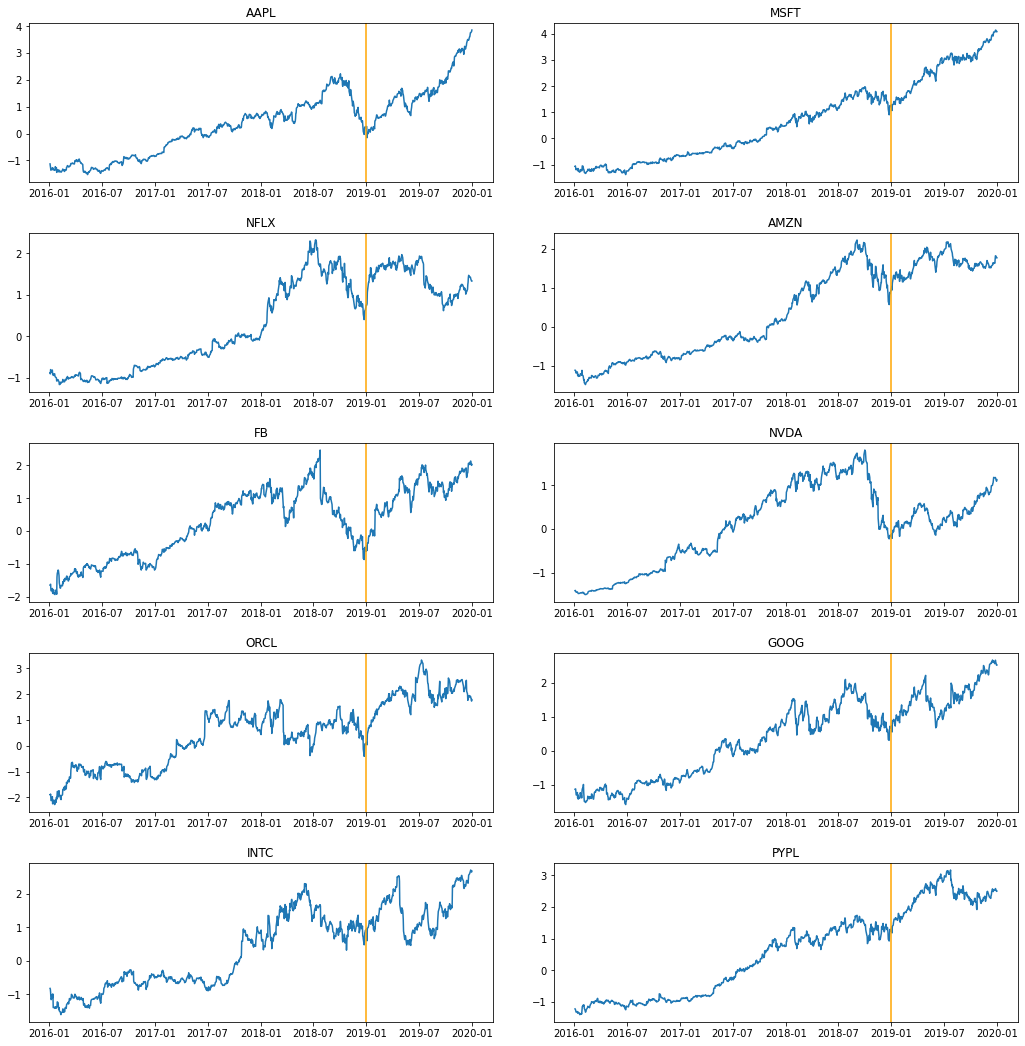

In [12]:
#Subplots of alls stocks
Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']

fig, axs = plt.subplots(5, 2,figsize=(15,15))
fig.tight_layout(pad=3.0)

for i in range(len(Tick)):
    axs[i%5, i%2].plot(NormPrices['PRC',Tick[i]])
    axs[i%5, i%2].set_title(Tick[i])
    #Added in line where test data will be split
    axs[i%5, i%2].axvline(dt.datetime(2018, 12, 31), color='orange')

#Added vertical line to indicate split

In [13]:
#To check how many Nulls etc
#UnstackedPrices.info()

In [14]:
#To examine values and distibutions/ make sure normalizaiton worked
#UnstackedPrices.describe()

## Feature Engineering Part 2

Another commonly used technique used in feature engineering of time series data is the use of lag features. These types of features are generated by shifting the dataset to obtain the previous days' values. In this case, lag features up to 20 days were generated. Although this results in a large number of variables, feature selection is used later in this notebook to identify the most useful features.

In [15]:
#Feature names to lag, and steps to lag by
Feat = ['PRC','VOL', 'OPENPRC',  'ASKHI', 'BIDLO', 'WKDY'] 
Steps = 20

In [16]:
idx = UnstackedPrices.index

#Adding in detrended prices and returns
for k in Tick:
    s = detrendPrice(UnstackedPrices['PRC',k])
    s.index = idx
    NormPrices['DETPRC',k] = s
    
for k in Tick:
    s = detrendPrice(UnstackedPrices['OPENPRC',k])
    s.index = idx
    NormPrices['DETOPENPRC',k] = s
    
for k in Tick:
    s = np.log(NormPrices['DETPRC', k].shift(-1)/NormPrices['DETPRC', k])
    s.index = idx
    NormPrices['DETDLYRET',k] = s
    
for k in Tick:
    s = np.log(UnstackedPrices['PRC', k].shift(-1)/UnstackedPrices['PRC', k])
    s.index = idx
    NormPrices['DLYRET',k] = s
    
for k in Tick:
    s = np.log(NormPrices['DETOPENPRC', k].shift(-2)/NormPrices['DETPRC', k].shift(-1))
    s.index = idx
    NormPrices['DETRET',k] = s

In [17]:
#Trimming data
NormPrices = NormPrices[:-2] #drop two rows, used to calculate returns
NormPrices = NormPrices[20:] #drop 20 rows, used to calculate volatility

#Need this for unlagged variables
NormPrices2 = NormPrices[Steps:] #trim data used to calculate lags
NormPrices2 = NormPrices2.stack(dropna=False)
NormPrices2 = pd.DataFrame(NormPrices2)
NormPrices2.reset_index(inplace=True)
NormPrices2.sort_values(by=['TICKER', 'date'], inplace=True)

#Unlagged variables, saving for later 
OPENTRD = NormPrices2['OPENTRD']
FIVESTDPRC = NormPrices2['5STDPRC']
TWENTYSTDPRC = NormPrices2['20STDPRC']
AVGPRC = NormPrices2['5AVGPRC']
STDVOL = NormPrices2['5STDVOL']

#Return and other variables for WRC
DETPRC = NormPrices2['DETPRC']
DETOPENPRC = NormPrices2['DETOPENPRC']
DETDLYRET = NormPrices2['DETDLYRET']
DLYRET = NormPrices2['DLYRET']
DETRET = NormPrices2['DETRET']

#Restacking Data
NormPrices = MyStack(NormPrices)

#Adding day of week
NormPrices['WKDY'] = NormPrices['date'].dt.dayofweek #lag or dont lag weekeday???
NormPrices.reset_index(inplace=True, drop=True)

In [18]:
#Function to add lagged variables based on steps, and assembles data frame
def LagVar(X, steps, values):
    
    UnstackX = pd.pivot_table(X, values=values, index=['date'], columns=['TICKER'], aggfunc=np.sum)
    UnstackXTrim = UnstackX[steps:]
    UnstackXTrim  = MyStack(UnstackXTrim)
    UnstackXTrim.reset_index(inplace=True, drop=True)
    
    X = UnstackXTrim
    
    for i in range(steps):
 
        Shifted1 = UnstackX.shift(periods=i+1)
        Shifted1 = Shifted1[steps:]
        Shifted2 = Shifted1.stack(dropna=False)
        Shifted2.reset_index(inplace=True)
        Shifted2.sort_values(by=['TICKER', 'date'], inplace=True)
        Shifted2.reset_index(inplace=True, drop=True)
        Shifted3 = Shifted2.add_prefix(('Lag_' + str(i+1) + '_' ))
        Shifted3.drop([('Lag_' + str(i+1) + '_date' )], axis=1, inplace=True)
        Shifted3.drop([('Lag_' + str(i+1) + '_TICKER' )], axis=1, inplace=True)

        X = pd.concat([X, Shifted3], axis = 1)
    
    return(X)

In [19]:
#Lagging data
LagData = LagVar(NormPrices, Steps, Feat) 
LagData.reset_index(inplace=True, drop=True)
LagData.head() #Check for NaNs

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_19_OPENPRC,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_ASKHI,Lag_20_BIDLO,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
0,2016-03-02,AAPL,-1.266602,-1.261195,-1.256156,-1.252633,-0.004563,2,-1.269747,-1.320653,...,-1.402013,-1.369251,0.838201,2.0,-1.393714,-1.404751,-1.390895,-1.418814,0.269771,1.0
1,2016-03-03,AAPL,-1.245114,-1.239501,-1.254303,-1.232755,0.244027,3,-1.266602,-1.261195,...,-1.379248,-1.362625,0.866888,3.0,-1.372748,-1.410107,-1.402013,-1.369251,0.838201,2.0
2,2016-03-04,AAPL,-1.191645,-1.214861,-1.206920,-1.192734,0.843501,4,-1.245114,-1.239501,...,-1.361777,-1.431005,0.863348,4.0,-1.359905,-1.380378,-1.379248,-1.362625,0.866888,3.0
3,2016-03-07,AAPL,-1.215757,-1.225842,-1.206390,-1.222948,0.175583,0,-1.191645,-1.214861,...,-1.451514,-1.404766,1.361416,0.0,-1.370651,-1.420552,-1.361777,-1.431005,0.863348,4.0
4,2016-03-08,AAPL,-1.243801,-1.240840,-1.249009,-1.245212,-0.109882,1,-1.215757,-1.225842,...,-1.420807,-1.405296,0.726635,1.0,-1.402625,-1.437961,-1.451514,-1.404766,1.361416,0.0


In [20]:
LagData.tail() #Check for NaNs if issue

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,Lag_19_OPENPRC,Lag_19_PRC,Lag_19_VOL,Lag_19_WKDY,Lag_20_ASKHI,Lag_20_BIDLO,Lag_20_OPENPRC,Lag_20_PRC,Lag_20_VOL,Lag_20_WKDY
9635,2019-12-20,PYPL,2.500332,2.569228,2.553239,2.528225,0.305868,4,2.466381,2.534768,...,2.231083,2.174361,-0.465589,4.0,2.243207,2.261659,2.235136,2.213904,-0.219171,3.0
9636,2019-12-23,PYPL,2.491844,2.582087,2.541589,2.521128,-0.874720,0,2.500332,2.569228,...,2.203730,2.310228,-0.034317,0.0,2.181297,2.188110,2.231083,2.174361,-0.465589,4.0
9637,2019-12-24,PYPL,2.482358,2.582087,2.520821,2.525184,-1.550875,1,2.491844,2.582087,...,2.326312,2.398948,1.061867,1.0,2.248199,2.257030,2.203730,2.310228,-0.034317,0.0
9638,2019-12-26,PYPL,2.506822,2.591859,2.545641,2.578922,-1.011254,3,2.482358,2.582087,...,2.432177,2.477528,-0.213383,2.0,2.358539,2.382527,2.326312,2.398948,1.061867,1.0
9639,2019-12-27,PYPL,2.528291,2.608832,2.598168,2.561178,-1.163451,4,2.506822,2.591859,...,2.486883,2.490710,-0.921634,4.0,2.431432,2.500822,2.432177,2.477528,-0.213383,2.0


## Target

The target variable was cleaned and prepared for model development. In this analysis, the target is the log of the “overnight” returns from market close on day of trade, to sell next morning.

In [21]:
#Close price from next day
ClosePrc = UnstackedPrices['PRC'].shift(periods=-1)
ClosePrc = ClosePrc[:-2]
ClosePrc = ClosePrc[Steps+20:]
ClosePrc = ClosePrc.stack(dropna=False)
ClosePrc = pd.DataFrame(ClosePrc)
ClosePrc.reset_index(inplace=True)
ClosePrc.sort_values(by=['TICKER', 'date'], inplace=True)
ClosePrc.rename({0: 'PRC'}, axis=1, inplace = True)

#Open price from day after
OpenPrc2 = UnstackedPrices['OPENPRC'].shift(periods=-2)
OpenPrc2 = OpenPrc2[:-2]
OpenPrc2 = OpenPrc2[Steps+20:]
OpenPrc2 = OpenPrc2.stack(dropna=False)
OpenPrc2 = pd.DataFrame(OpenPrc2)
OpenPrc2.reset_index(inplace=True)
OpenPrc2.sort_values(by=['TICKER', 'date'], inplace=True)
OpenPrc2.rename({0: 'OPENPRC'}, axis=1, inplace = True)

In [22]:
#Calculating Log Returns
OpenPrc2['ClosePrc'] = ClosePrc['PRC']
OpenPrc2['Returns'] = np.log(OpenPrc2['OPENPRC']/OpenPrc2['ClosePrc'])
Returns = pd.DataFrame(OpenPrc2['Returns'])
Returns.reset_index(inplace=True, drop=True)

array([[<AxesSubplot:title={'center':'Returns'}>]], dtype=object)

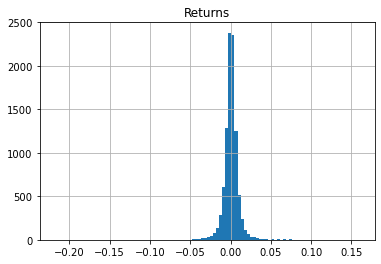

In [23]:
#Distribution of returns
Returns.hist(bins=100)

In [24]:
#Add year for splitting based on year
LagData['YEAR'] = LagData['date'].dt.year

#Adding back unlagged variables
LagData['RET'] = Returns 
LagData['OPENTRD'] = OPENTRD
LagData['5STDPRC'] = FIVESTDPRC
LagData['20STDPRC'] = TWENTYSTDPRC
LagData['5AVGPRC'] = AVGPRC
LagData['5STDVOL'] = STDVOL
LagData['DETPRC'] = DETPRC
LagData['DETOPENPRC'] = DETOPENPRC
LagData['DETDLYRET'] = DETDLYRET
LagData['DLYRET'] = DLYRET
LagData['DETRET'] = DETRET

In [25]:
LagData.head()

,date,TICKER,ASKHI,BIDLO,OPENPRC,PRC,VOL,WKDY,Lag_1_ASKHI,Lag_1_BIDLO,...,OPENTRD,5STDPRC,20STDPRC,5AVGPRC,5STDVOL,DETPRC,DETOPENPRC,DETDLYRET,DLYRET,DETRET
0,2016-03-02,AAPL,-1.266602,-1.261195,-1.256156,-1.252633,-0.004563,2,-1.269747,-1.320653,...,-1.257315,0.177648,-0.775594,-1.320622,-1.320622,66.817717,64.425055,0.009037,0.007417,-0.021371
1,2016-03-03,AAPL,-1.245114,-1.239501,-1.254303,-1.232755,0.244027,3,-1.266602,-1.261195,...,-1.249616,-0.181427,-0.102754,-1.282946,-1.282946,359.156918,359.480274,-0.011932,-0.004699,0.002310
2,2016-03-04,AAPL,-1.191645,-1.214861,-1.206920,-1.192734,0.843501,4,-1.245114,-1.239501,...,-1.362924,-0.372550,-0.022999,-1.431693,-1.431693,50.124558,50.914916,-0.009081,-0.003371,0.028720
3,2016-03-07,AAPL,-1.215757,-1.225842,-1.206390,-1.222948,0.175583,0,-1.191645,-1.214861,...,-1.271137,-0.211773,-0.601101,-1.330781,-1.330781,193.444738,188.895139,-0.037038,-0.008985,-0.014759
4,2016-03-08,AAPL,-1.243801,-1.240840,-1.249009,-1.245212,-0.109882,1,-1.215757,-1.225842,...,-1.207542,-0.201640,-0.639447,-1.367950,-1.367950,8.911014,8.690998,0.001610,0.001309,-0.009640


## Splitting Data

Although the data was previously split into the training and test set when performing feature scaling, the code below was used to do the formal split after feature generation. Data from 2016-2018 was used as the training dataset and data from 2019 was used for testing. The goal of this is to ensure that the model is able to learn from the training data but still generalize well enough to make predictions on data it has never seen before (i.e. the test data).

It is important to note that although the raw data was time series data, the data that was used in the model was cross-sectional in nature.

In [26]:
#Splitting data, 2019 is test set
X_train = LagData[LagData['YEAR'] != TestYear]
X_train.drop(['RET', 'YEAR', 'date', 'TICKER', 'DETPRC', 'DETOPENPRC', 'DETDLYRET', 'DLYRET', 'DETRET'], axis=1, inplace=True)
tick_train = LagData[LagData['YEAR'] != TestYear]['TICKER']

y_train = LagData[LagData['YEAR'] != TestYear]
y_train = y_train['RET']

X_test = LagData[LagData['YEAR'] == TestYear]
X_test.drop(['RET', 'YEAR', 'date', 'TICKER', 'DETPRC', 'DETOPENPRC', 'DETDLYRET', 'DLYRET', 'DETRET'], axis=1, inplace=True)
tick_test = LagData[LagData['YEAR'] == TestYear]['TICKER']

y_test = LagData[LagData['YEAR'] == TestYear]
y_test = y_test['RET']

## Feature Selection

Feature selection is used to identify the variables with the most predictive power. There are many feature selection techniques that can be used. In this analysis, the "SelectKBest" method was used. This is a form of univariate feature selection where the relationship between each feature and the target variable was evaluated. Only features with a score greater than the mean were included. This threshold was selected empirically.

5.587745257405553e-06 1.0988656138664663 6.0261828140174005


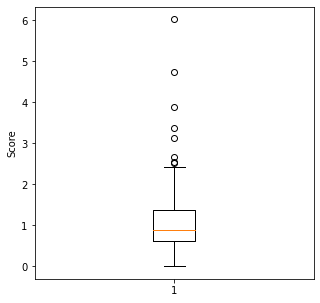

In [27]:
# Select k Best features
kbest = SelectKBest(score_func=f_regression, k='all')
fs = kbest.fit(X_train, y_train)
fs_scores = fs.scores_

print(min(fs_scores), np.mean(fs_scores), max(fs_scores))

fig = plt.figure(figsize =(5, 5)) 
plt.boxplot(fs_scores) 
plt.ylabel("Score")
plt.show() 

<AxesSubplot:>

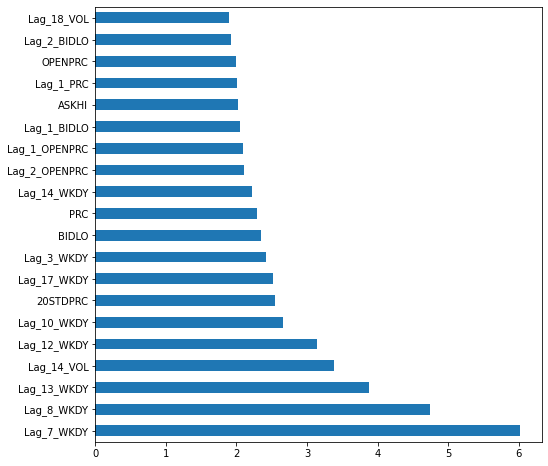

In [28]:
#Feature Importance
fs_scores_plt = pd.Series(fs_scores, index=X_train.columns)
fs_scores_plt.nlargest(20).plot(kind='barh', figsize=(8,8))

In [29]:
# Only select features with a score greater than the mean
feat_thresh = np.mean(fs_scores)
mask = fs_scores>feat_thresh
kbest_feat = X_train.columns[mask]
print(str(len(kbest_feat)) + " features selected")

52 features selected


In [30]:
kbest = SelectKBest(score_func=f_regression, k=len(kbest_feat))
fs = kbest.fit(X_train, y_train)
# Transform train and test data
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

## Model Implementation

Three models were implemented. Hyperparameter tuning using grid search was performed for each model. This regularization was done to find the optimal parameter values that resulted in the best performance. It was also done to prevent overfitting on the training set.

In [31]:
# Helper functions for model evaluation

# Most scores are already implemented, just have to implement sMAPE
def smape(actual, predicted):
    n = len(actual)
    return 50/n * np.sum(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted)))

# Calculate all metrics
def calc_metrics(actual, predicted):
    rmse = mean_squared_error(actual, predicted, squared=False)
    s = smape(actual, predicted)
    return [rmse, s]

### Linear Regression (Ridge)

In [32]:
# Set up hyperparameter tuning for Ridge Regression
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10]
fit_intercept = [False]

lr_grid = {'alpha': alpha,
           'fit_intercept': fit_intercept}
print(lr_grid)

# Initialize model
lr = Ridge()
# Random search of parameters, using 3 fold cross validation, 
cv = GridSearchCV(lr, lr_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'fit_intercept': [False]}
{'alpha': 10, 'fit_intercept': False}


In [33]:
# Re-train on full dataset using best parameters
lr_best = Ridge(alpha = 1, fit_intercept = False, random_state=42)
# Fit on train data
lr_best.fit(X_train, y_train)

Ridge(alpha=1, fit_intercept=False, random_state=42)

In [34]:
# Evaluate performance on train and test data

# Predictions for train data
y_train_pred = lr_best.predict(X_train)
lr_train_perf = calc_metrics(y_train, y_train_pred)
print(lr_train_perf)
# Predictions for test data
y_test_pred = lr_best.predict(X_test)
lr_test_perf = calc_metrics(y_test, y_test_pred)
print(lr_test_perf)

[0.011422217067167947, 79.72386477702665]
[0.011036055240997229, 82.89514458210085]


Text(0.5, 1.0, 'Top 15 Features')

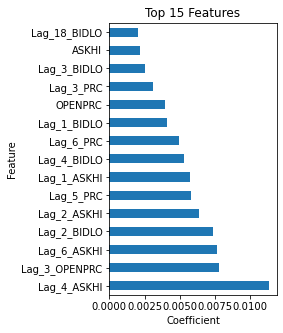

In [35]:
#Feature Importance
feat_importances = pd.Series(lr_best.coef_, index=kbest_feat)
ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(3,5))
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Top 15 Features")

### Random Forest

In [36]:
# Set up hyperparameter tuning for Random Forest
# Number of trees in random forest
n_estimators = [25, 50, 75, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2, 3, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 20, 30, 40, 50]
# Method of selecting samples for training each tree
bootstrap = [True]

rf_grid = {'n_estimators': n_estimators,
           'max_features': max_features,
           'max_depth': max_depth,
           'min_samples_leaf': min_samples_leaf,
           'bootstrap': bootstrap}
print(rf_grid)

# Initialize model
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
cv = GridSearchCV(rf, rf_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs = -1)
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'n_estimators': [25, 50, 75, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 3, 5, 7, 10], 'min_samples_leaf': [10, 20, 30, 40, 50], 'bootstrap': [True]}
{'bootstrap': True, 'max_depth': 7, 'max_features': 'auto', 'min_samples_leaf': 40, 'n_estimators': 50}


In [37]:
# Re-train on full dataset using best parameters
rf_best = RandomForestRegressor(n_estimators = 75, 
                                min_samples_leaf = 10,
                                max_features = 'auto',
                                max_depth = 10,
                                bootstrap = True,
                                random_state=42)
# Fit on train data
rf_best.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=10, n_estimators=75,
                      random_state=42)

In [38]:
# Evaluate performance on train and test data

# Predictions for train data
y_train_pred = rf_best.predict(X_train)
rf_train_perf = calc_metrics(y_train, y_train_pred)
print(rf_train_perf)
# Predictions for test data
y_test_pred = rf_best.predict(X_test)
rf_test_perf = calc_metrics(y_test, y_test_pred)
print(rf_test_perf)

[0.010521469615515889, 73.5111104110064]
[0.015427813290047167, 82.60433702185581]


Text(0.5, 1.0, 'Top 15 Features')

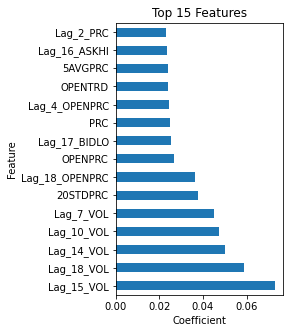

In [39]:
#Feature Importance
feat_importances = pd.Series(rf_best.feature_importances_, index=kbest_feat)
ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(3,5))
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Top 15 Features")

### Gradient Boosted Trees

In [40]:
# Set up hyperparameter tuning for Gradient Boosted Trees (XGBoost)

# Number of trees 
n_estimators = [25, 50, 75, 100]
# Maximum number of levels in tree
max_depth = [3, 5, 7, 10]
# Learning rate to prevent overfitting
learning_rate = [0.1, 0.2, 0.3, 0.4]

xgb_grid = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'learning_rate': learning_rate}
print(xgb_grid)

# Initialize model
xgbreg = XGBRegressor(nthreads=-1)
# Random search of parameters, using 3 fold cross validation, 
cv = GridSearchCV(xgbreg, xgb_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)  
# Fit the random search model
cv.fit(X_train, y_train)

# Get best model
print(cv.best_params_)

{'n_estimators': [25, 50, 75, 100], 'max_depth': [3, 5, 7, 10], 'learning_rate': [0.1, 0.2, 0.3, 0.4]}
[20:03:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 25}


In [41]:
# Re-train on full dataset using best parameters
xgbreg_best = XGBRegressor(n_estimators = 25, max_depth = 3, learning_rate = 0.3, random_state=42)

xgbreg_best.fit(X_train, y_train)

[20:03:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(learning_rate=0.3, n_estimators=25, random_state=42)

In [42]:
# Evaluate performance on train and test data

# Predictions for train data
y_train_pred = xgbreg_best.predict(X_train)
xgb_train_perf = calc_metrics(y_train, y_train_pred)
print(xgb_train_perf)

# Predictions for test data
y_test_pred = xgbreg_best.predict(X_test)
xgb_test_perf = calc_metrics(y_test, y_test_pred)
print(xgb_test_perf)

[0.0107140007541385, 77.9488961453767]
[0.02391377404530959, 79.46252172604288]


Text(0.5, 1.0, 'Top 15 Features')

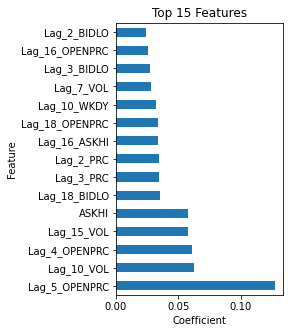

In [43]:
#Feature Importance
feat_importances = pd.Series(xgbreg_best.feature_importances_, index=kbest_feat)
ax = feat_importances.nlargest(15).plot(kind='barh', figsize=(3,5))
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Top 15 Features")

## Model Evaluation - Predictive Performance

Predictive performance was evaluated by comparing the true return values against the predicted return.

Two metrics were considered based on their common use in industry. For both metrics, a lower value is preferable.
- Root Mean-Squared Error (RMSE)
- Symmetric Mean Absolute Percentage Error (sMAPE)

In general, the random forest model was found to have the best predictive performance.

In [44]:
# Predictive performance on test data
df_model_perf = pd.DataFrame(columns=['Model','Train RMSE','Train sMAPE','Test RMSE','Test sMAPE'])
df_model_perf.loc[0] = ['LR']+lr_train_perf+lr_test_perf
df_model_perf.loc[1] = ['RF']+rf_train_perf+rf_test_perf
df_model_perf.loc[2] = ['GBT']+xgb_train_perf+xgb_test_perf
df_model_perf

,Model,Train RMSE,Train sMAPE,Test RMSE,Test sMAPE
0,LR,0.011422,79.723865,0.011036,82.895145
1,RF,0.010521,73.511110,0.015428,82.604337
2,GBT,0.010714,77.948896,0.023914,79.462522


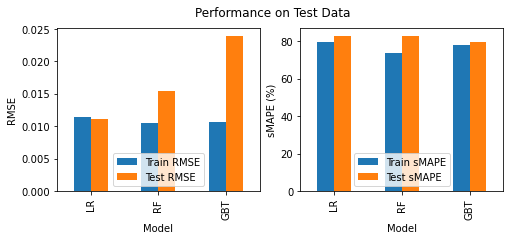

In [45]:
# Plot performance metrics
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Performance on Test Data')
df_model_perf.plot.bar(x='Model', y=['Train RMSE','Test RMSE'], ax=axes[0], ylabel='RMSE')
df_model_perf.plot.bar(x='Model', y=['Train sMAPE','Test sMAPE'], ax=axes[1], ylabel='sMAPE (%)')
axes[0].legend(loc = 'lower center')

## Model Evaluation - Financial Performance

The financial performance was evaluated by quantifying the outcome of each trading strategy. This was done by performing backtesting on each model. 

For each strategy, three metrics were used:
Three metrics were considered:
- Cumulative Returns
- Compound Annual Growth Rate (CAGR)
- Sharpe Ratio

In [46]:
def prep_data(best_mdl):
    #Adding Prediction to test data
    TestData = LagData[LagData['YEAR'] == TestYear]
    TestData['PREDRET'] = best_mdl.predict(X_test)

    #Unstacking test data for backtesting
    col = ['TICKER', 'date', 'RET', 'PREDRET','DETPRC','DETOPENPRC','DETDLYRET','DLYRET','DETRET']
    UnstackTest = TestData[col]
    UnstackTest = pd.pivot_table(UnstackTest, values=['RET', 'PREDRET','DETPRC','DETOPENPRC','DETDLYRET','DLYRET','DETRET'], index=['date'], \
                                 columns=['TICKER'], aggfunc=np.sum)

    #Setting up training data for backtesting optimization
    TrainData = LagData[LagData['YEAR'] != TestYear]
    TrainData['PREDRET'] = best_mdl.predict(X_train)

    #Unstacking train data for backtesting
    col = ['TICKER','date','RET', 'PREDRET','DETPRC','DETOPENPRC','DETDLYRET','DLYRET','DETRET']
    UnstackTrain = TrainData[col]
    UnstackTrain = pd.pivot_table(UnstackTrain, values=['RET', 'PREDRET','DETPRC','DETOPENPRC','DETDLYRET','DLYRET','DETRET'], index=['date'], \
                                  columns=['TICKER'], aggfunc=np.sum)
    
    return UnstackTest, UnstackTrain

In [47]:
#Backtesting function
def BackTest(X, Threshold, short=False):
    Tick = ['AAPL' , 'AMZN', 'FB', 'GOOG', 'INTC', 'MSFT', 'NFLX', 'NVDA', 'ORCL', 'PYPL']
    
    for Tick in Tick:
        #Applying signal for each asset if threshold is passed
        X['SIGNAL', Tick] = 0
        
        #Apply buy signal
        mask = (X['PREDRET',Tick] > Threshold)
        X['SIGNAL', Tick][mask] = 1 
        
        if short == True:
            #Apply sell signal
            mask = (X['PREDRET',Tick] < -Threshold)
            X['SIGNAL', Tick][mask] = -1 
        
        #Calculating Returns based on signals
        X['TRADERET', Tick] = X['SIGNAL', Tick] * X['RET', Tick] 
        #Detrended returns
        X['DETSTRATRET', Tick]=X['DETRET', Tick] * X['SIGNAL', Tick] 
    
    #Calculating returns
    X['HOLDINGS'] = (X['SIGNAL'].abs()).sum(axis=1) #Number of assets bought each day, used to find average return
    X['TOTRET'] = (X['TRADERET'].sum(axis=1) / X['HOLDINGS']) #total returns by number of holding, this is portfolio returns
    X['TOTRET'] = X['TOTRET'].fillna(0) 
    
    X['TOTDETRET'] = (X['DETSTRATRET'].sum(axis=1) / X['HOLDINGS']) #total returns by number of holding, this is portfolio returns
    X['TOTDETRET'] = X['TOTDETRET'].fillna(0)
    
    #Cummulative Returns
    X['STRAT_CUMRET'] = X['TOTRET'].cumsum() #Cummulative Returns
    X['LONG_CUMRET'] = (X['DLYRET'].sum(axis=1)/10).cumsum() #Returns for equal position long portfolio
    
    #Strategy metrics
    strat_ann_vol = X['TOTRET'].std()*math.sqrt(252)
    strat_ann_ret = ((X['TOTRET'].mean()+1)**252) - 1
    strat_ann_sr = X['TOTRET'].mean()/(X['TOTRET'].std())*math.sqrt(252) #Sharpes Ratio
    strat_ann_cagr = (1 + X['STRAT_CUMRET'][-1]) ** (252 / len(X['TOTRET'])) - 1  #CAGR
    
    #Baseline Long Portfolio metrics
    long_ann_vol = (X['DLYRET'].sum(axis=1)/10).std()*math.sqrt(252)
    long_ann_ret = (((X['DLYRET'].sum(axis=1)/10).mean()+1)**252) - 1
    long_ann_sr = (X['DLYRET'].sum(axis=1)/10).mean()/((X['DLYRET'].sum(axis=1)/10).std())*math.sqrt(252)
    long_ann_cagr = (1 + X['LONG_CUMRET'][-1]) ** (252 / len(X['DLYRET'])) - 1 
    
    return(X, strat_ann_vol, strat_ann_ret, strat_ann_sr, strat_ann_cagr, \
           long_ann_vol, long_ann_ret, long_ann_sr, long_ann_cagr)

In [48]:
#optimizing threshold parameter based on training data
def BackTestOpt(X):

    lin = np.linspace(0, 0.005, 200)
    returns = []
    
    #Testing Various Thresholds
    for i in lin:
        Y, strat_ann_vol, strat_ann_ret, strat_ann_sr, strat_ann_cagr, \
            long_ann_vol, long_ann_ret, long_ann_sr, long_ann_cagr \
            = BackTest(X, i)
        returns.append(strat_ann_ret)
    
    
    df = (pd.DataFrame([lin, returns])).T
    df.columns = ['Threshold','Returns']
    df['rollavg'] = df['Returns'].rolling(window=5).mean() #Smoothing out bumps
    
    #Finding threshold with max returns
    idx = df['rollavg'].idxmax()
    val1 = df['Returns'][idx]
    val2 = df['Threshold'][idx]
    
    #Plotting Threshold vs annualized Returns
    df.index = df['Threshold']
    df['Returns'].plot()
    df['rollavg'].plot()
    plt.title('Trading Threshold vs Trading Returns')
    plt.ylabel('Annualized Returns')
    
    return(val1, val2)

### Linear Regression Trading Strategy

In [49]:
XTrade_lr, Xopt_lr = prep_data(lr_best)

0.00073


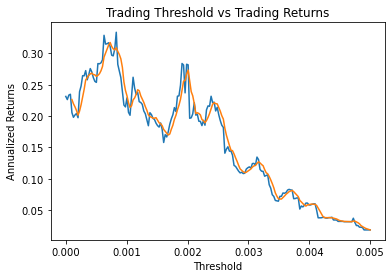

In [50]:
#Find optimal threshold based on train data, doesnt really work since model knows this data too well, cant generalize this threshold
ret, thresh = BackTestOpt(Xopt_lr)
print(round(thresh,5))

0.0001


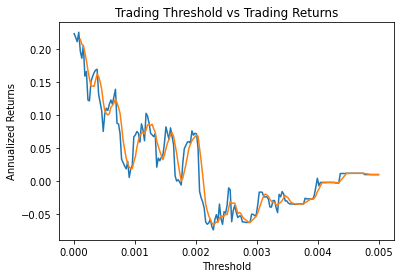

In [51]:
ret, thresh = BackTestOpt(XTrade_lr)
print(round(thresh,5))

### Random Forest Trading Strategy

In [52]:
XTrade_rf, Xopt_rf = prep_data(rf_best)

0.00221


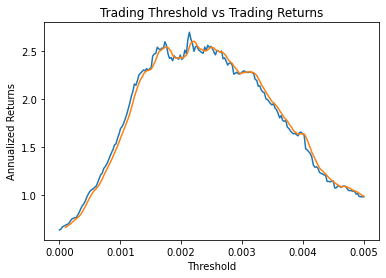

In [53]:
ret, thresh = BackTestOpt(Xopt_rf)
print(round(thresh,5))

0.0001


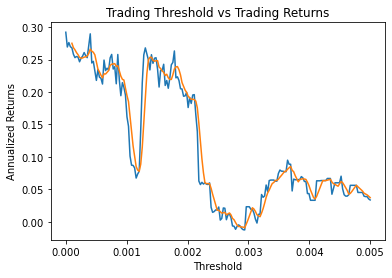

In [54]:
ret, thresh = BackTestOpt(XTrade_rf)
print(round(thresh,5))

### Gradient Boosted Trees Trading Strategy

In [55]:
XTrade_xgb, Xopt_xgb = prep_data(xgbreg_best)

0.00188


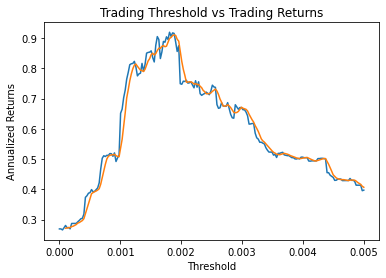

In [56]:
ret, thresh = BackTestOpt(Xopt_xgb)
print(round(thresh,5))

0.00138


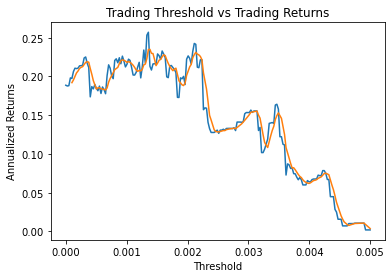

In [57]:
ret, thresh = BackTestOpt(XTrade_xgb)
print(round(thresh,5))

### Trading Results For All Models

The three models were evaluated using the financial metrics above. The performance was compared against a equal weighted buy and hold strategy. 

With a “buy the close, sell the open” strategy, the Random Forest model was able to outperform a “buy and hold” strategy with returns of 26% vs 21.7%.

In [58]:
def get_trading_results(data, threshold, model_name, short=False):
    #Backtest on test data with optimal or manual threshold
    XTrade, strat_ann_vol, strat_ann_ret, strat_ann_sr, strat_ann_cagr, \
        long_ann_vol, long_ann_ret, long_ann_sr, long_ann_cagr \
        = BackTest(data, threshold, short)
    
    print("Strategy Results: Annualized Volatility: %0.4f Annualized Returns: %0.4f Sharpe Ratio: %0.4f CAGR: %0.4f" \
          % (round(strat_ann_vol,4), round(strat_ann_ret,4), round(strat_ann_sr,4), round(strat_ann_cagr,4)))
    print("Equal Long Portfolio Results: Annualized Volatility: %0.4f Annualized Returns: %0.4f Sharpe Ratio: %0.4f CAGR: %0.4f" \
          % (round(long_ann_vol,4), round(long_ann_ret,4), round(long_ann_sr,4), round(long_ann_cagr,4)))
    
    # Summarize results for random forest portfolio
    XTrade['STRAT_CUMRET'].shift(periods=1).plot(figsize=(5,3))
    XTrade['LONG_CUMRET'].plot(figsize=(5,3))
    plt.legend([model_name+' Portfolio', 'Equal Portfolio'], loc="upper left")
    plt.title(model_name+' Portfolio vs Equal Portfolio')
    plt.ylabel("Cumulative Return")
    plt.show()    

Strategy Results: Annualized Volatility: 0.1265 Annualized Returns: 0.1983 Sharpe Ratio: 1.4308 CAGR: 0.1811
Equal Long Portfolio Results: Annualized Volatility: 0.0923 Annualized Returns: 0.2171 Sharpe Ratio: 2.1294 CAGR: 0.1967


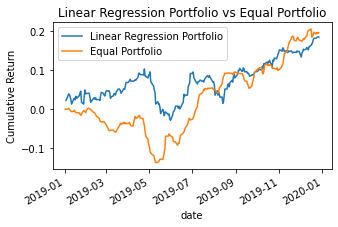

In [59]:
# Linear Regression
threshold_lr = 0.0001 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh
get_trading_results(XTrade_lr, threshold_lr, "Linear Regression", short)

Strategy Results: Annualized Volatility: 0.1438 Annualized Returns: 0.2595 Sharpe Ratio: 1.6053 CAGR: 0.2310
Equal Long Portfolio Results: Annualized Volatility: 0.0923 Annualized Returns: 0.2171 Sharpe Ratio: 2.1294 CAGR: 0.1967


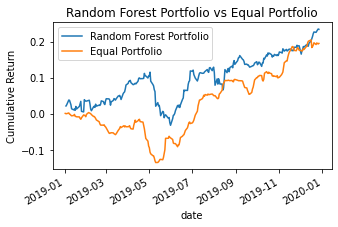

In [60]:
# Random Forest
threshold_rf = 0.0003 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh
get_trading_results(XTrade_rf, threshold_rf, "Random Forest", short)

Strategy Results: Annualized Volatility: 0.1190 Annualized Returns: 0.2095 Sharpe Ratio: 1.5987 CAGR: 0.1904
Equal Long Portfolio Results: Annualized Volatility: 0.0923 Annualized Returns: 0.2171 Sharpe Ratio: 2.1294 CAGR: 0.1967


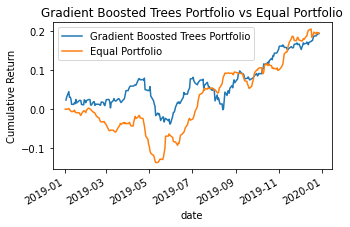

In [61]:
# Gradient Boosted Trees
threshold_xgb = 0.001 #used this based on approximating form previous tests, adds buffer for predictions around 0
short = False
#Threshold = thresh
get_trading_results(XTrade_xgb, threshold_xgb, "Gradient Boosted Trees", short)

## Whites Reality Check

White’s Reality Check (WRC) indicates that the null hypothesis should not be rejected, and that the strategy returns on detrended prices would not be profitable.
WRC requires that we detrend the overnight returns which seems to violate the basis of the model.
The model assumes, and historically proves, that regardless of the asset returns there is a long term increasing trend in overnight returns.
We aim to capitalize on this trend in the best way possible with the use of our models, and therefore we do not believe that WRC fully applies to our situation.

In [62]:
#White's Reality Check, resued from class function
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)
    
        #histogram
    sr = pd.Series(mb)
    desc = sr.describe()
    count = desc[0]
    std = desc[2]
    minim = desc[3]
    maxim = desc[7]
    R = maxim-minim
    n = count
    s = std
    bins = int(round(R*(n**(1/3))/(3.49*std),0))
    fig = sr.hist(bins=bins)
    plt.show()

    print("p_value:")
    print(p)
    return p

average return -0.019271
[-0.00413355  0.00413586]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)


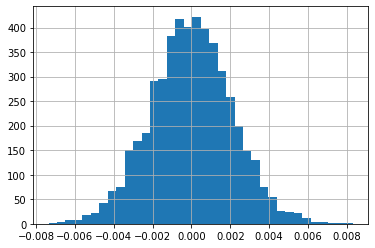

p_value:
0.9998


0.9998

In [63]:
#Whites Reality Check
bootstrap(XTrade_rf['TOTDETRET'])

## Additional Plots

The graphs below were generated for use in the presentation slides.

### Trade Signal Visual

An example of the thresholds used to generate "buy", "sell" or "hold" signals.

Text(0.5, 1.0, 'Predicted Returns with Trading Thresholds Example')

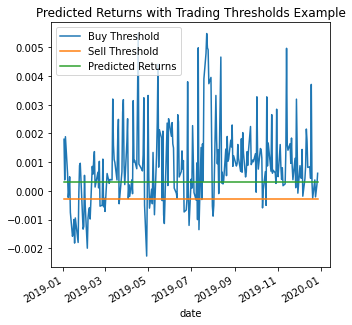

In [64]:
Signal = pd.DataFrame(XTrade_rf['PREDRET', 'NFLX'])
Signal['RETURNS'] = XTrade_rf['RET', 'NFLX']
Signal['UPPER'] = 0.0003
Signal['LOWER'] = -0.0003
Signal['PREDRET', 'NFLX'].plot(figsize=(5,5))
Signal['LOWER'].plot()
Signal['UPPER'].plot()
plt.legend(['Buy Threshold', 'Sell Threshold', 'Predicted Returns'], loc="upper left")
plt.title('Predicted Returns with Trading Thresholds Example')

### Breakeven Visual

Demonstrate the profit required to breakeven, given transaction costs.

In [65]:
#Results from Random Forest
BestReturns = 0.260
BaseReturns = 0.217
ExcessReturns = BestReturns - BaseReturns

In [66]:
#Assume retail cost per trade of $10
CPT = 10

In [67]:
nTrades = XTrade_rf['HOLDINGS'].sum()
cost = CPT*nTrades
investment = np.linspace(1000, 1000000, 10)
breakeven = pd.DataFrame(investment)
breakeven.columns = ['InitialInvestment']
breakeven['Profit'] = breakeven['InitialInvestment'] * ExcessReturns - cost

Text(0.5, 1.0, 'Breakeven Analysis')

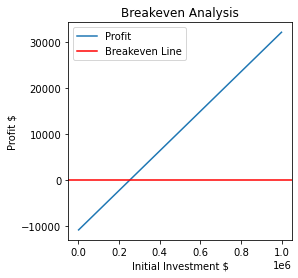

In [68]:
plt.figure(figsize=(4,4))
plt.plot(breakeven['InitialInvestment'], breakeven['Profit'])
plt.axhline(0, c='red')
plt.legend(['Profit', 'Breakeven Line'])
plt.xlabel('Initial Investment $')
plt.ylabel('Profit $')
plt.title('Breakeven Analysis')